# Model 2
We therefore built a logistic regression model (inherent properties model) to predict the probability P($a_i=1$) that a biobank $i$ will be top-tier ($h$-index is an outlier of the distribution) two years after its publication:


$$
 \text{log}\frac{P(a_i=1)}{1- P(a_i=1)} \propto \beta_1 \times g_i + \beta_2 \times r_i + \beta_3 \times c_i + \beta_4 \times n_i + \beta_5 \times f_i.
$$

Given the gender of its lead ($g_i$), the rank of their affiliation $r_i$, their citations at the time the biobank was created kind $c_i$ (log scale), the team size of the biobank $n_i$ (log scale), and its female propotion $f_i$.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
cohort = pd.read_csv('../../small_data/processed/manual_cohort.csv')
cohort = cohort[cohort['Year'] <= 2019]
cohort = cohort[(cohort['Hindex'] > 0)]
cohort = cohort[(cohort['CitationPI'] > 0)]

In [3]:
cohort['Lead'] = cohort['PI']
cohort['LeadCitationCount'] = cohort['CitationPI']

# I. Let get information about the team

In [5]:
authors = pd.read_csv('../../small_data/cohort_author_affiliation_big_model.csv')

### 1) Gender of PI

In [8]:
pi_gender = authors.groupby('AuthorId')['gender'].first().reset_index()
pi_gender.columns = ['Lead', 'LeadGender']

cohort = cohort.merge(pi_gender, how='left')

### 2) PI Affiliation rank

In [9]:
pi_aff_rank = authors.groupby('AuthorId')['rank_affiliation'].first().reset_index()
pi_aff_rank.columns = ['Lead', 'AffiliationRank']
cohort = cohort.merge(pi_aff_rank, how='left')

### 3) Lead citations at the biobank creation

### 4) Team size

In [10]:
size = authors.groupby('PaperId').size().reset_index()
size.columns = ['PaperId', 'TeamSize']
cohort = cohort.merge(size, how='left')

### 5) Female proportion

In [11]:
fem = authors.groupby('PaperId')['male_proportion'].first().reset_index()
fem['FemalePropotion'] = 1 - fem['male_proportion']
del fem['male_proportion']
cohort = cohort.merge(fem, how='left')

# II. Prepare the model

### Response variable is 1 if $h$-index of biobank is an outlier

In [30]:
cohort['outlier1'] = 0
q75 = cohort['Hindex'].quantile(.75)
q25 = cohort['Hindex'].quantile(.25)
cohort.loc[cohort['Hindex'] >= 1.5 * (q75 - q25), 'outlier1'] = 1

In [31]:
cohort['TopLead'] = 0
q75 = cohort['LeadCitationCount'].quantile(.75)
q25 = cohort['LeadCitationCount'].quantile(.25)
cohort.loc[cohort['LeadCitationCount'] >= 1.5 * (q75 - q25), 'TopLead'] = 1

In [32]:
cohort['LargeTeam'] = 0
q75 = cohort['TeamSize'].quantile(.75)
q25 = cohort['TeamSize'].quantile(.25)
cohort.loc[cohort['TeamSize'] >= 1.5 * (q75 - q25), 'LargeTeam'] = 1

In [33]:
cohort['Balanced'] = 0
cohort.loc[cohort['FemalePropotion'].between(0.45, .55), 'Balanced'] = 1

In [34]:
features = [
    'LeadGender',
    'AffiliationRank',
    'LeadCitationCount',
    'TeamSize',
    'Balanced'
]

c = cohort.copy()
c = c.dropna(subset=features)

c['outlier1'] = 0
q75 = c['Hindex'].quantile(.75)
q25 = c['Hindex'].quantile(.25)
c.loc[c['Hindex'] >= 1.5 * (q75 - q25), 'outlier1'] = 1

cohort_t = c[features + ['outlier1']].copy().dropna()



cohort_t['LeadGender'] = cohort_t['LeadGender'].replace({'female': 1,
                                             'male': 0})

#cohort_t['AffiliationRank'] = np.log10(cohort_t['AffiliationRank'])

cohort_t['LeadCitationCount'] = np.log10(cohort_t['LeadCitationCount'] + 1)

cohort_t['TeamSize'] = np.log2(cohort_t['TeamSize'])

X, y = cohort_t[features].values, cohort_t['outlier1'].values

scaler = MinMaxScaler((0, 1))

X = scaler.fit_transform(X)

In [35]:
## prop_0 = cohort_t['outlier1'].value_counts(normalize=True).loc[0]
prop_1 = cohort_t['outlier1'].value_counts(normalize=True).loc[1]

clf = LogisticRegression(class_weight={0: 0.2, 1: .7}, C=1000)

scores = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')
cv_results = cross_validate(clf, X, y, cv=10, return_estimator=True)

print(f"The mean AUC for this model is {np.mean(scores)}")

The mean AUC for this model is 0.6071428571428571


In [36]:
C = []
for est in cv_results['estimator']:
    C.append(est.coef_)
C = np.concatenate(C)
coef = np.mean(C, axis=0)
coef = pd.DataFrame([coef], columns=features)
coef

,LeadGender,AffiliationRank,LeadCitationCount,TeamSize,Balanced
0,0.581011,-1.653791,1.810981,1.295531,0.58026


In [37]:
scaler.transform([[0, 3.65, 3, 3, 1]])

array([[ 0.        , -0.51642673,  0.28784535,  0.49632766,  1.        ]])

In [38]:
cv_results['estimator'][0].predict_proba(scaler.transform([[1, 3.65, 4, 3, 1]]))

array([[0.13024311, 0.86975689]])

In [39]:
cv_results['estimator'][0].predict_proba(scaler.transform([[1, 3.65, 3, 3, 1]]))

array([[0.18353202, 0.81646798]])

In [40]:
cv_results['estimator'][0].predict_proba(scaler.transform([[0, 3.65, 4, 3, 0]]))

array([[0.26642761, 0.73357239]])

In [41]:
coef.columns = ['PI Gender', 'PI Affiliation rank', 'PI Citations', 'Team\nSize', 'Gender\nBalance']

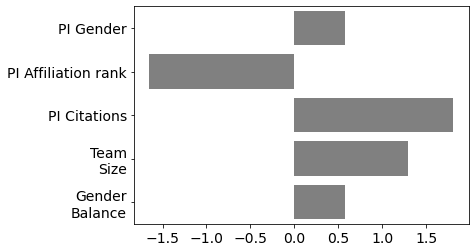

In [42]:
ax = sns.barplot(data=coef, orient='h', color='gray')
ax.set_ylabel('Model Coefficent')
ax.set_ylabel('')

plt.yticks(fontsize=14)
plt.xticks(rotation=0, fontsize=14);